# REMB Production Algorithm - Fixed Version

This notebook implements the REMB (Real Estate Master Planning Bot) algorithm with:
- **GPU Acceleration** via OR-Tools parallel workers
- **DXF Input Support** for reading cadastral boundaries
- **DXF Export** preserving all original data
- **JSON Intermediate Format** for data flow

## Fixes Applied:
1. KeyError in infrastructure graph visualization (node ID mismatch)
2. GPU/parallel workers for OR-Tools optimization
3. DXF file input handling
4. DXF export with data preservation

In [1]:
# 0. INSTALL DEPENDENCIES
!pip install shapely matplotlib networkx ortools scikit-learn scipy numpy ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 require

In [2]:
# 1. IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon, LineString, MultiLineString, box
from shapely.ops import unary_union, voronoi_diagram
from shapely import affinity
import networkx as nx
from ortools.sat.python import cp_model
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
import random
import math
import os
import json
from datetime import datetime

print("✅ All imports successful")

✅ All imports successful


In [3]:
# 2. CONFIGURATION - Industrial Zone Standards (TCVN)

# --- A. Roads & Planning ---
ROAD_MAIN_WIDTH = 30.0      # Main road width (m) - Truck passing
ROAD_INTERNAL_WIDTH = 15.0  # Internal road width (m)
SIDEWALK_WIDTH = 4.0        # Sidewalk each side (m)
TURNING_RADIUS = 15.0       # Container truck turning radius (m)

# --- B. Land Use & Zoning ---
SERVICE_AREA_RATIO = 0.10   # 10% for infrastructure (Admin, WTP, Parking)
MIN_BLOCK_AREA = 5000       # Minimum block area for subdivision (m²)

# --- C. Building Regulations (TCVN) ---
SETBACK_DISTANCE = 6.0      # Building setback from road (m)
FIRE_SAFETY_GAP = 4.0       # Fire safety gap between buildings (m)

# --- D. Lot Subdivision (OR-Tools) ---
MIN_LOT_WIDTH = 20.0        # Minimum industrial lot frontage (m)
MAX_LOT_WIDTH = 80.0        # Maximum lot width (m)
TARGET_LOT_WIDTH = 40.0     # Target lot width (m)
MIN_LOT_DEPTH = 30.0        # Minimum lot depth (m)
MAX_LOT_DEPTH = 100.0       # Maximum lot depth (m)
TARGET_LOT_DEPTH = 50.0     # Target lot depth (m)
PLOT_SPACING = 10.0         # Spacing between plots (m)

# --- E. GPU/Solver Settings ---
SOLVER_TIME_LIMIT = 2.0     # Time limit per block (seconds)
USE_GPU = True              # Enable GPU acceleration if available

# --- F. Infrastructure ---
TRANSFORMER_RADIUS = 300    # Transformer service radius (m)

print("✅ Configuration loaded")

✅ Configuration loaded


In [4]:
# 3. GPU DETECTION & SETUP

def check_gpu_available():
    """Check if GPU/CUDA is available"""
    try:
        import ctypes
        try:
            ctypes.CDLL("libcuda.so.1")  # Linux
            return True
        except OSError:
            try:
                ctypes.CDLL("nvcuda.dll")  # Windows
                return True
            except OSError:
                return False
    except:
        return False

GPU_AVAILABLE = check_gpu_available()
NUM_WORKERS = os.cpu_count() or 4

if GPU_AVAILABLE:
    print(f"✅ GPU detected - using CUDA acceleration")
    print(f"   Workers: {NUM_WORKERS}")
else:
    print(f"⚠️ GPU not available - using CPU parallel workers")
    print(f"   Workers: {NUM_WORKERS}")

✅ GPU detected - using CUDA acceleration
   Workers: 2


ℹ️ Using random generated site (no DXF provided)

Site Area: 22.76 ha


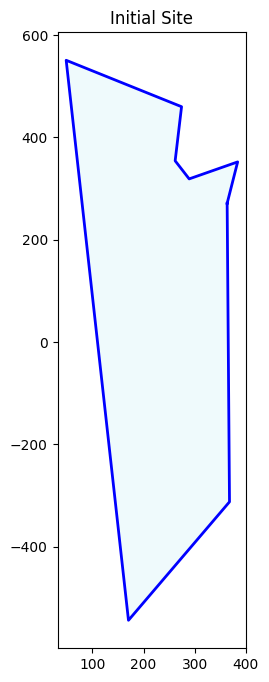

In [5]:
# 4. DXF INPUT HANDLING (Optional - for real cadastral data)

def load_boundary_from_dxf(dxf_path):
    """Load cadastral boundary from DXF file"""
    try:
        import ezdxf

        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()

        # Find the largest closed polygon (likely the boundary)
        largest_polygon = None
        max_area = 0

        for entity in msp:
            if entity.dxftype() == 'LWPOLYLINE' and entity.is_closed:
                points = list(entity.get_points(format='xy'))
                if len(points) >= 3:
                    poly = Polygon(points)
                    if poly.is_valid and poly.area > max_area:
                        max_area = poly.area
                        largest_polygon = poly

        if largest_polygon:
            print(f"✅ Loaded boundary from DXF: {dxf_path}")
            print(f"   Area: {largest_polygon.area / 10000:.2f} ha")
            return largest_polygon, doc
        else:
            print(f"⚠️ No valid boundary found in DXF")
            return None, None

    except Exception as e:
        print(f"❌ Error loading DXF: {e}")
        return None, None

def create_random_site():
    """Create a random polygon representing industrial zone (~50 ha)"""
    angles = np.sort(np.random.rand(8) * 2 * np.pi)
    radii = 400 + np.random.rand(8) * 200
    points = np.c_[radii * np.cos(angles), radii * np.sin(angles)]
    site = Polygon(points)
    return site

def get_elevation(x, y):
    """Simulate terrain: slopes from NW to SE"""
    return 50.0 - (x * 0.02) - (y * 0.03)

# Try to load from DXF, or create random site
DXF_PATH = None  # Set to your DXF file path if available
original_doc = None

if DXF_PATH and os.path.exists(DXF_PATH):
    site_polygon, original_doc = load_boundary_from_dxf(DXF_PATH)
    if site_polygon is None:
        site_polygon = create_random_site()
else:
    site_polygon = create_random_site()
    print("ℹ️ Using random generated site (no DXF provided)")

minx, miny, maxx, maxy = site_polygon.bounds
print(f"\nSite Area: {site_polygon.area / 10000:.2f} ha")

# Plot initial site
fig, ax = plt.subplots(figsize=(8, 8))
x, y = site_polygon.exterior.xy
ax.fill(x, y, color='#e0f7fa', alpha=0.5, label='Site Boundary')
ax.plot(x, y, color='blue', linewidth=2)
ax.set_title("Initial Site")
ax.set_aspect('equal')
plt.show()

In [6]:
# 5. PHASE 1: ROAD NETWORK & ZONING

from shapely.geometry import GeometryCollection

def generate_road_network(site, num_seeds=15):
    """Generate Voronoi-based road network"""
    minx, miny, maxx, maxy = site.bounds

    # Create Voronoi seeds
    seeds = [Point(random.uniform(minx, maxx), random.uniform(miny, maxy)) for _ in range(num_seeds)]

    # Generate Voronoi diagram
    regions = voronoi_diagram(MultiPolygon([site.buffer(100)]), envelope=site.buffer(200))

    # Extract edges
    edges = []
    if hasattr(regions, 'geoms'):
        for region in regions.geoms:
            if region.geom_type == 'Polygon':
                edges.append(region.exterior)
    elif regions.geom_type == 'Polygon':
        edges.append(regions.exterior)

    # Classify roads: Main vs Internal
    center = site.centroid
    road_polys = []

    merged_lines = unary_union(edges)
    lines_to_process = list(merged_lines.geoms) if hasattr(merged_lines, 'geoms') else [merged_lines]

    for line in lines_to_process:
        if not isinstance(line, (LineString, MultiLineString)):
            continue

        dist_to_center = line.distance(center)
        if dist_to_center < 100 or line.length > 400:
            width = ROAD_MAIN_WIDTH + 2 * SIDEWALK_WIDTH
        else:
            width = ROAD_INTERNAL_WIDTH + 2 * SIDEWALK_WIDTH

        road_polys.append(line.buffer(width / 2, cap_style=2, join_style=2))

    if not road_polys:
        return [], [], Polygon()

    network_poly = unary_union(road_polys)

    # Smooth corners (turning radius)
    smooth_network = network_poly.buffer(TURNING_RADIUS, join_style=1).buffer(-TURNING_RADIUS, join_style=1)

    # Create blocks (site minus roads)
    blocks_rough = site.difference(smooth_network)

    service_blocks = []
    commercial_blocks = []

    candidates = list(blocks_rough.geoms) if hasattr(blocks_rough, 'geoms') else [blocks_rough] if blocks_rough.geom_type == 'Polygon' else []

    # Sort by elevation (lowest for wastewater)
    candidates.sort(key=lambda b: get_elevation(b.centroid.x, b.centroid.y))

    total_area = sum([b.area for b in candidates])
    current_service_area = 0

    # Lowest block -> Wastewater treatment
    if candidates:
        wwtp = candidates.pop(0)
        service_blocks.append({'geom': wwtp, 'type': 'XLNT (Lowest)'})
        current_service_area += wwtp.area

    for b in candidates:
        if (current_service_area < total_area * SERVICE_AREA_RATIO) or (b.area < MIN_BLOCK_AREA):
            service_blocks.append({'geom': b, 'type': 'Admin/Parking'})
            current_service_area += b.area
        else:
            commercial_blocks.append(b)

    return commercial_blocks, service_blocks, smooth_network

# Generate road network
blocks, service_blocks, road_network = generate_road_network(site_polygon)
print(f"✅ Commercial blocks: {len(blocks)}")
print(f"   Service blocks: {len(service_blocks)}")

✅ Commercial blocks: 5
   Service blocks: 4


In [7]:
# 6. PHASE 2: LOT SUBDIVISION WITH GPU ACCELERATION

def solve_subdivision_with_gpu(total_len, min_w, max_w, target_w, use_gpu=True):
    """Solve lot subdivision with GPU-accelerated OR-Tools"""
    model = cp_model.CpModel()
    max_lots = int(total_len // min_w) + 2

    widths = []
    is_active = []
    diffs = []

    for i in range(max_lots):
        w = model.NewIntVar(0, int(max_w * 10), f'w_{i}')
        active = model.NewBoolVar(f'active_{i}')

        model.Add(w >= int(min_w * 10)).OnlyEnforceIf(active)
        model.Add(w <= int(max_w * 10)).OnlyEnforceIf(active)
        model.Add(w == 0).OnlyEnforceIf(active.Not())

        diff = model.NewIntVar(0, int(max_w * 10), f'diff_{i}')
        model.Add(diff >= w - int(target_w * 10)).OnlyEnforceIf(active)
        model.Add(diff >= int(target_w * 10) - w).OnlyEnforceIf(active)
        model.Add(diff == 0).OnlyEnforceIf(active.Not())

        widths.append(w)
        is_active.append(active)
        diffs.append(diff)

    total_w_var = model.NewIntVar(0, int(total_len * 10), 'total_w')
    model.Add(total_w_var == sum(widths))

    # Maximize fill & minimize deviation
    model.Maximize(total_w_var * 100 - sum(diffs))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = SOLVER_TIME_LIMIT

    # GPU/Parallel configuration
    if use_gpu and GPU_AVAILABLE:
        solver.parameters.num_workers = 0  # Auto-detect all cores
        solver.parameters.num_search_workers = 0
    else:
        solver.parameters.num_workers = NUM_WORKERS
        solver.parameters.num_search_workers = NUM_WORKERS

    status = solver.Solve(model)

    results = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for i in range(max_lots):
            if solver.Value(is_active[i]):
                results.append(solver.Value(widths[i]) / 10.0)

    return results

def calculate_legal_params(lot_polygon):
    """Calculate building density & setback"""
    buildable_area = lot_polygon.buffer(-SETBACK_DISTANCE)

    if buildable_area.is_empty:
        return None, 0, 0

    area_m2 = lot_polygon.area
    if area_m2 < 3000:
        density = 0.70
    elif area_m2 < 10000:
        density = 0.65
    else:
        density = 0.60

    max_build_area = area_m2 * density
    return buildable_area, density * 100, max_build_area

# Process blocks
final_lots = []
print("\n🔄 Processing lot subdivision...")

for idx, block in enumerate(blocks):
    rect = block.minimum_rotated_rectangle
    x, y = rect.exterior.coords.xy
    edge_lengths = [Point(x[i], y[i]).distance(Point(x[i+1], y[i+1])) for i in range(4)]
    max_idx = np.argmax(edge_lengths)
    total_len = edge_lengths[max_idx]

    # Solve with GPU acceleration
    widths = solve_subdivision_with_gpu(total_len, MIN_LOT_WIDTH, MAX_LOT_WIDTH, TARGET_LOT_WIDTH, USE_GPU)

    # Geometric cutting
    p0 = np.array([x[max_idx], y[max_idx]])
    p1 = np.array([x[(max_idx+1)%4], y[(max_idx+1)%4]])
    vec = p1 - p0
    vec_len = np.linalg.norm(vec)
    if vec_len == 0:
        continue
    unit_vec = vec / vec_len
    ortho = np.array([-unit_vec[1], unit_vec[0]])

    curr = 0
    for w in widths:
        start = p0 + unit_vec * curr
        end = p0 + unit_vec * (curr + w)
        cutter = Polygon([start - ortho*500, end - ortho*500, end + ortho*500, start + ortho*500])
        lot = block.intersection(cutter)

        if not lot.is_empty and lot.area > 500:
            if isinstance(lot, MultiPolygon):
                for g in lot.geoms:
                    final_lots.append(g)
            else:
                final_lots.append(lot)
        curr += w

# Calculate legal parameters
processed_lots = []
for lot in final_lots:
    b_zone, density, max_area = calculate_legal_params(lot)
    if b_zone is not None:
        processed_lots.append({
            'geom': lot,
            'buildable': b_zone,
            'density': density,
            'max_area': max_area
        })

print(f"✅ Generated {len(processed_lots)} commercial lots")


🔄 Processing lot subdivision...
✅ Generated 29 commercial lots


In [8]:
# 7. PHASE 3: INFRASTRUCTURE (FIXED VERSION)

def create_loop_network(lots):
    """
    Create electrical loop network.
    FIXED: Properly handle node ID mapping to avoid KeyError
    """
    if not lots:
        return nx.Graph(), {}

    centroids = [l['geom'].centroid for l in lots]
    G = nx.Graph()

    # Add nodes with position
    for i, p in enumerate(centroids):
        G.add_node(i, pos=(p.x, p.y))

    # Add edges based on distance
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = centroids[i].distance(centroids[j])
            if dist < 150:
                G.add_edge(i, j, weight=dist)

    # Handle disconnected graph
    if not nx.is_connected(G) and len(G.nodes()) > 0:
        components = list(nx.connected_components(G))
        if components:
            largest_comp = max(components, key=len)
            G = G.subgraph(largest_comp).copy()

    # Create MST if graph has edges
    if len(G.edges()) > 0:
        mst = nx.minimum_spanning_tree(G)
        loop_graph = mst.copy()

        # Add extra edges for redundancy
        all_edges = sorted(G.edges(data=True), key=lambda x: x[2].get('weight', 0))
        target_extra = max(1, int(len(G.nodes()) * 0.15))
        added_count = 0

        for u, v, data in all_edges:
            if not loop_graph.has_edge(u, v):
                loop_graph.add_edge(u, v, weight=data.get('weight', 0))
                added_count += 1
                if added_count >= target_extra:
                    break
    else:
        loop_graph = G

    # CRITICAL FIX: Build pos from ACTUAL graph nodes, not original list
    pos = {}
    for node in loop_graph.nodes():
        if node < len(centroids):
            pos[node] = (centroids[node].x, centroids[node].y)

    return loop_graph, pos

# Create infrastructure
print("\n🔄 Calculating infrastructure...")

if len(processed_lots) > 0:
    infra_graph, infra_pos = create_loop_network(processed_lots)
else:
    infra_graph = nx.Graph()
    infra_pos = {}

# Transformer placement with K-Means
transformer_locs = np.array([])
if len(processed_lots) > 0:
    lot_coords = np.array([[l['geom'].centroid.x, l['geom'].centroid.y] for l in processed_lots])
    num_transformers = max(1, int(len(processed_lots) / 15))
    num_transformers = min(num_transformers, len(processed_lots))

    if num_transformers > 0:
        kmeans = KMeans(n_clusters=num_transformers, n_init=10, random_state=42).fit(lot_coords)
        transformer_locs = kmeans.cluster_centers_

# Drainage (gravity flow)
wwtp_loc = None
for s in service_blocks:
    if "XLNT" in s['type']:
        wwtp_loc = s['geom'].centroid
        break
if wwtp_loc is None:
    wwtp_loc = site_polygon.centroid

flow_arrows = []
for lot in processed_lots:
    c = lot['geom'].centroid
    dx = wwtp_loc.x - c.x
    dy = wwtp_loc.y - c.y
    length = math.sqrt(dx**2 + dy**2)
    if length > 0:
        flow_arrows.append((c.x, c.y, dx/length*30, dy/length*30))

print(f"✅ Infrastructure calculated")
print(f"   Transformers: {len(transformer_locs)}")
print(f"   Grid nodes: {len(infra_graph.nodes())}")
print(f"   Grid edges: {len(infra_graph.edges())}")


🔄 Calculating infrastructure...
✅ Infrastructure calculated
   Transformers: 1
   Grid nodes: 15
   Grid edges: 16


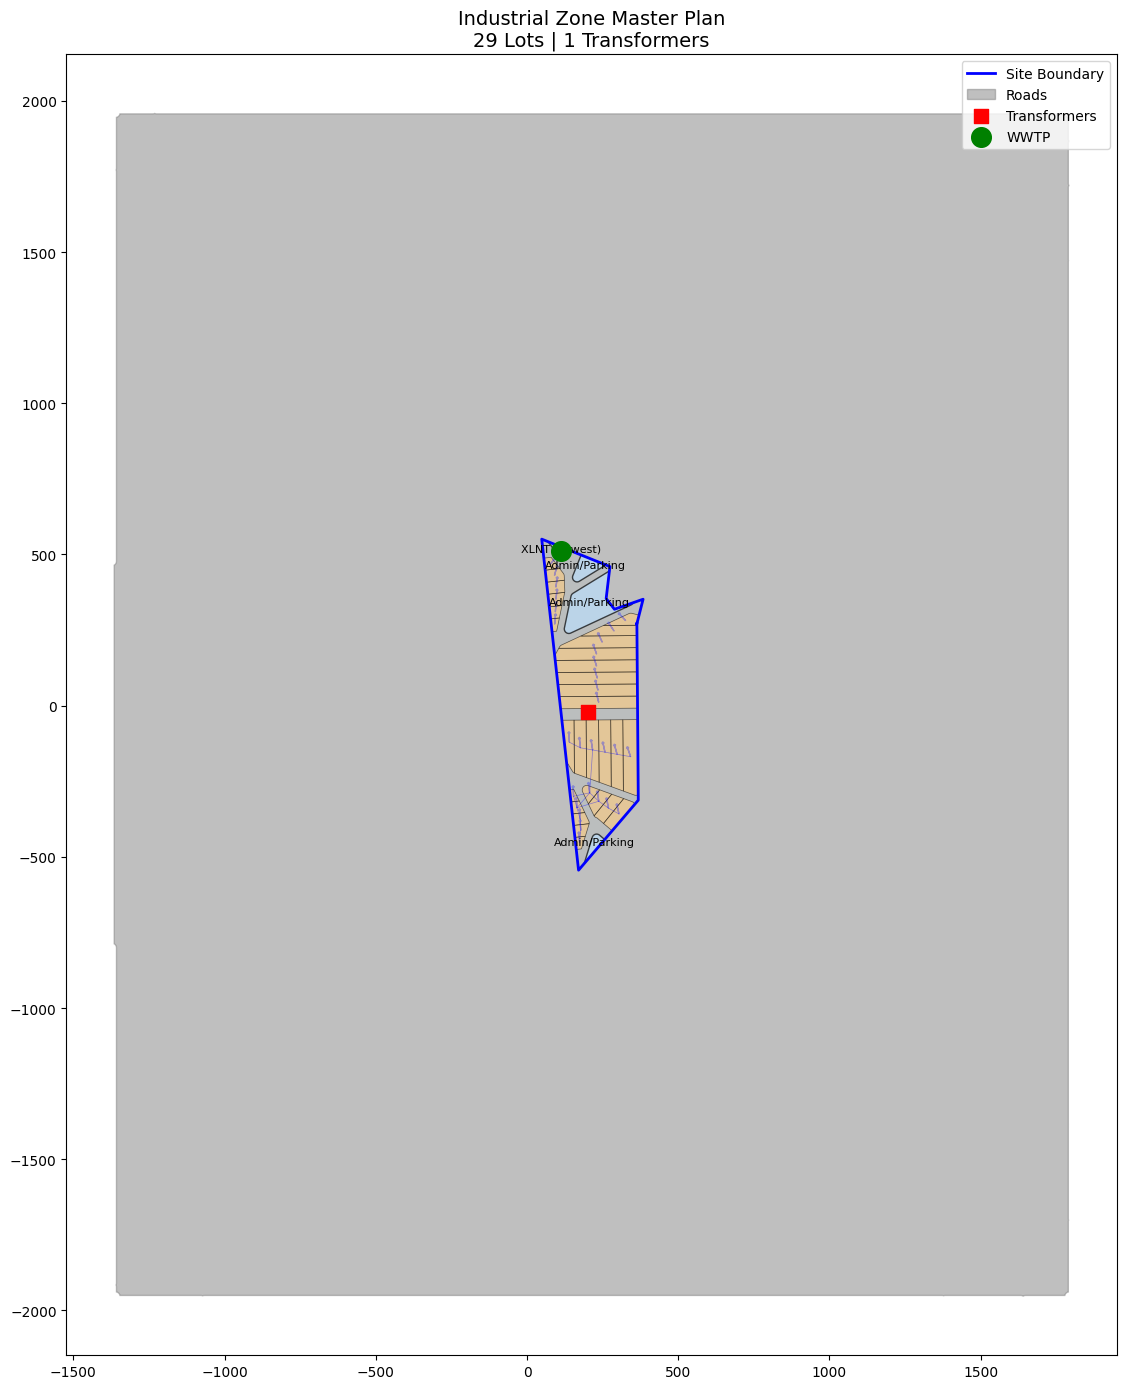


✅ Visualization complete


In [9]:
# 8. VISUALIZATION (FIXED VERSION)

fig, ax = plt.subplots(figsize=(14, 14))

# Site boundary
x, y = site_polygon.exterior.xy
ax.fill(x, y, color='#e0f7fa', alpha=0.2)
ax.plot(x, y, color='blue', linewidth=2, label='Site Boundary')

# Road network
if road_network and not road_network.is_empty:
    if hasattr(road_network, 'geoms'):
        for geom in road_network.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, color='gray', alpha=0.5)
    else:
        x, y = road_network.exterior.xy
        ax.fill(x, y, color='gray', alpha=0.5, label='Roads')

# Commercial lots
for lot in processed_lots:
    geom = lot['geom']
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.fill(x, y, color='#ffcc80', alpha=0.6, edgecolor='black', linewidth=0.5)

# Service blocks
for s in service_blocks:
    geom = s['geom']
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        color = '#c8e6c9' if 'XLNT' in s['type'] else '#bbdefb'
        ax.fill(x, y, color=color, alpha=0.7, edgecolor='black', linewidth=1)
        ax.text(geom.centroid.x, geom.centroid.y, s['type'], fontsize=8, ha='center')

# Infrastructure grid (FIXED)
for u, v in infra_graph.edges():
    if u in infra_pos and v in infra_pos:  # Check if nodes exist in pos
        p1 = infra_pos[u]
        p2 = infra_pos[v]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue',
                linestyle='-', linewidth=0.5, alpha=0.4)

# Transformers
if len(transformer_locs) > 0:
    ax.scatter(transformer_locs[:, 0], transformer_locs[:, 1],
               c='red', s=100, marker='s', zorder=10, label='Transformers')

# Flow arrows
for (x, y, dx, dy) in flow_arrows:
    ax.arrow(x, y, dx, dy, head_width=8, head_length=5,
             fc='lightblue', ec='blue', alpha=0.3)

# WWTP marker
if wwtp_loc:
    ax.scatter(wwtp_loc.x, wwtp_loc.y, c='green', s=200,
               marker='o', zorder=10, label='WWTP')

ax.set_title(f"Industrial Zone Master Plan\n{len(processed_lots)} Lots | {len(transformer_locs)} Transformers", fontsize=14)
ax.set_aspect('equal')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")

In [10]:
# 9. JSON OUTPUT (Intermediate Format)

def create_optimization_result():
    """Create JSON output with all optimization results"""
    result = {
        'timestamp': datetime.now().isoformat(),
        'site_area_m2': site_polygon.area,
        'site_area_ha': site_polygon.area / 10000,
        'plots': [],
        'roads': [],
        'service_blocks': [],
        'transformers': [],
        'config': {
            'road_main_width': ROAD_MAIN_WIDTH,
            'road_internal_width': ROAD_INTERNAL_WIDTH,
            'setback_distance': SETBACK_DISTANCE,
            'plot_spacing': PLOT_SPACING,
            'min_lot_width': MIN_LOT_WIDTH,
            'max_lot_width': MAX_LOT_WIDTH,
            'target_lot_width': TARGET_LOT_WIDTH
        },
        'used_gpu': GPU_AVAILABLE
    }

    # Add plots
    for i, lot in enumerate(processed_lots):
        geom = lot['geom']
        centroid = geom.centroid
        result['plots'].append({
            'id': f'plot_{i+1}',
            'x': centroid.x,
            'y': centroid.y,
            'area': geom.area,
            'density': lot['density'],
            'max_build_area': lot['max_area'],
            'coords': list(geom.exterior.coords)
        })

    # Add service blocks
    for i, s in enumerate(service_blocks):
        geom = s['geom']
        result['service_blocks'].append({
            'id': f'service_{i+1}',
            'type': s['type'],
            'area': geom.area,
            'coords': list(geom.exterior.coords)
        })

    # Add transformers
    for i, t in enumerate(transformer_locs):
        result['transformers'].append({
            'id': f'transformer_{i+1}',
            'x': float(t[0]),
            'y': float(t[1]),
            'radius': TRANSFORMER_RADIUS
        })

    # Calculate summary
    total_plot_area = sum([p['area'] for p in result['plots']])
    utilization = (total_plot_area / site_polygon.area) * 100

    result['summary'] = {
        'total_plots': len(result['plots']),
        'total_plot_area_m2': total_plot_area,
        'utilization_percent': utilization\n    }

    return result

# Create and save result
optimization_result = create_optimization_result()

with open('optimization_result.json', 'w') as f:
    json.dump(optimization_result, f, indent=2, default=str)

print("\n✅ JSON output saved: optimization_result.json")
print(f"   Plots: {optimization_result['summary']['total_plots']}")
print(f"   Utilization: {optimization_result['summary']['utilization_percent']:.1f}%")
print(f"   GPU used: {optimization_result['used_gpu']}")

SyntaxError: unexpected character after line continuation character (ipython-input-3199986298.py, line 65)

In [ ]:
# 10. DXF EXPORT (Preserving Original Data)

def export_to_dxf(output_path, original_doc=None):
    """Export optimization results to DXF, preserving original data if available"""
    import ezdxf

    # Use original doc or create new
    if original_doc:
        doc = original_doc
        print("✅ Preserving original DXF data")
    else:
        doc = ezdxf.new('R2010')
        print("ℹ️ Creating new DXF file")

    msp = doc.modelspace()

    # Add layers
    layers = {
        'OPTIMIZED_PLOTS': 3,      # Green
        'OPTIMIZED_ROADS': 1,      # Red
        'ANNOTATIONS': 7,          # White
        'INFRASTRUCTURE': 5,       # Blue
    }

    for layer_name, color in layers.items():
        if layer_name not in doc.layers:
            doc.layers.add(layer_name, color=color)

    # Add plots
    plot_count = 0
    for i, lot in enumerate(processed_lots):
        geom = lot['geom']
        if geom.geom_type == 'Polygon':
            points = list(geom.exterior.coords)
            msp.add_lwpolyline(points, close=True, dxfattribs={'layer': 'OPTIMIZED_PLOTS'})

            # Add label
            centroid = geom.centroid
            msp.add_text(
                f"Plot_{i+1}",
                dxfattribs={'layer': 'ANNOTATIONS', 'height': 5, 'insert': (centroid.x, centroid.y)}
            )
            plot_count += 1

    # Add transformers
    for i, t in enumerate(transformer_locs):
        msp.add_circle((float(t[0]), float(t[1])), radius=10, dxfattribs={'layer': 'INFRASTRUCTURE'})
        msp.add_text(
            f"TRF_{i+1}",
            dxfattribs={'layer': 'ANNOTATIONS', 'height': 8, 'insert': (float(t[0]), float(t[1]) + 15)}
        )

    # Add info block
    info_y = maxy + 100
    info_lines = [
        "OPTIMIZATION RESULTS",
        f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}",
        f"Plots: {len(processed_lots)}",
        f"GPU: {'Yes' if GPU_AVAILABLE else 'No'}",
    ]
    for line in info_lines:
        msp.add_text(line, dxfattribs={'layer': 'ANNOTATIONS', 'height': 10, 'insert': (minx, info_y)})
        info_y -= 15

    # Save
    doc.saveas(output_path)
    print(f"\n✅ DXF exported: {output_path}")
    print(f"   Plots added: {plot_count}")
    print(f"   Transformers added: {len(transformer_locs)}")

    return output_path

# Export
try:
    output_dxf = export_to_dxf('REMB_optimized_output.dxf', original_doc)
except Exception as e:
    print(f"❌ DXF export error: {e}")

In [ ]:
# 11. SUMMARY

print("\n" + "="*60)
print("REMB OPTIMIZATION COMPLETE")
print("="*60)
print(f"\n📊 Results:")
print(f"   Site Area: {site_polygon.area / 10000:.2f} ha")
print(f"   Commercial Plots: {len(processed_lots)}")
print(f"   Service Blocks: {len(service_blocks)}")
print(f"   Transformers: {len(transformer_locs)}")
print(f"   Grid Nodes: {len(infra_graph.nodes())}")
print(f"   Grid Edges: {len(infra_graph.edges())}")

if optimization_result:
    print(f"\n   Utilization: {optimization_result['summary']['utilization_percent']:.1f}%")

print(f"\n🖥️ GPU Used: {'Yes' if GPU_AVAILABLE else 'No'}")
print(f"   Workers: {NUM_WORKERS}")

print(f"\n📁 Output Files:")
print(f"   - optimization_result.json")
print(f"   - REMB_optimized_output.dxf")

print("\n" + "="*60)